In [57]:
import os
dir_data = r"C:/Users/Grzegorz Mróz/PycharmProjects/pythonProject"

for roots, folders, files in os.walk(dir_data):
    for file in files:
        if file.startswith('jena_climate'):
            fname = os.path.join(roots, file)

f = open(fname)
data = f.read()
f.close()

In [58]:
# 420451 próbek danych
# 1 próbka - linia (data poniaru 14 zmierzonych warości)
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]


In [59]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

In [60]:
import numpy as np
from matplotlib import pyplot as plt
#wykresy 14 wartości

#parsowanie danych 
float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:]=values
    
   

In [61]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [62]:
float_data.shape

(420451, 14)

<function matplotlib.pyplot.show(close=None, block=None)>

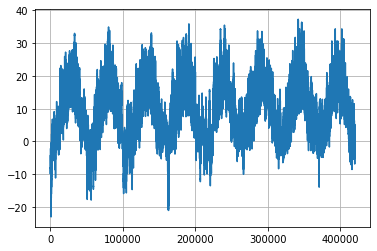

In [63]:
temp = float_data[:,1]# temp celcjusza
plt.plot(range(len(temp)), temp)
plt.grid()
plt.show
#okresowy trend roczy zmian temp.

In [64]:
6*24*10#dane co 10 min w godz 6 ptk x 24h = 1440(pierwsze 10 dni)

1440

<function matplotlib.pyplot.show(close=None, block=None)>

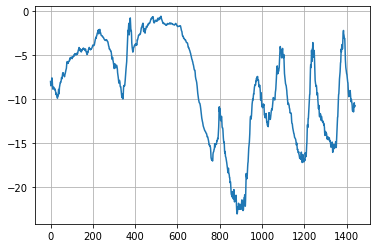

In [65]:
# wykres temp w ciagu 10 dni pomiar co 10 min
plt.plot(range(1440), temp[:1440])
plt.grid()
plt.show

In [48]:
# lookback = 720 #obserwacaje z ostatnich 5 dni (jedna obeserwacja co 10 min)
# step = 6 #wybiermay jedna obserwacje na godzine
# delay =144# chccemy przewidziec temp za 2 dni

In [49]:
# dane maja wasrtości liczbow nie trzeba wektoryzować
# dane maja różna skale daltego tzreba znormalizować (-20 +30 st.C, 10190 hPa)
# dane maja duża redundancje dlatego próbki trzeba generowac na bieżaco.

# OBLICZYC SREDNIA Z KAZDEGO SZEREGU I PODZIELIC PRZEZ ODCHYLENIE STD (pierwsze 20 000 próbek)

In [66]:
mean = float_data[:20000].mean(axis=0)
std = float_data[:20000].std(axis=0)


In [67]:
print(mean)
print(std)

[9.87683354e+02 4.39017050e+00 2.78544739e+02 5.23080000e-01
 7.82421180e+01 9.45993650e+00 6.84616500e+00 2.61373250e+00
 4.32741800e+00 6.93623500e+00 1.23744707e+03 2.04012400e+00
 3.42490600e+00 1.71542685e+02]
[10.43698592  7.64456982  7.82804682  5.96853777 15.88586242  5.15402052
  2.68174274  3.33775969  1.70035661  2.71840314 39.66767543  1.46425765
  2.24213234 89.21949358]


In [68]:
float_data -= mean # odajemujemy sr od kazdego elemantu
float_data /= std #dzielimy przez std`

In [71]:
float_data.shape[-1]

14

In [74]:
####### implemantacja generatora #######
#### zwraca próbki danaych szeregu czasowego i odpowiedajace im wartości dodelowe#########
## w kształcie krotki (wsady danych wejsciowych, tablica docelowych temp)
#(samples, targerts)

# krotka (samples, targest) sampl-wsad danych wejs, targest-tablica docelowych temp
# data - orginalana tablica danych float, które zostały znormalizowane
# lookback - liczba kroków czasu, do których powinny siegac dane wej
# delay - liczba kroków czasu okreslajacych przyszła temp
# min_index, max_index - indeksy tablicy dataokreslajace kroki, których próbki należy odczytać
#(przydatne do zbioru vali i test)
# shuffle - okresla to czy próbki mają byc losowane, czy pobierane w kloejności chronologicznej
# batch_size - liczba próbek wchodzących w skałd wasdu
# step - przedział czasu okreslajacy czestotliwośc probkowania danych(ustawinioe na 6 zeby odczytywać co godz)

#PREDYKCJA TEMP. DANIA NA PODSTAWIE OSTATNICH 5 DNI
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                                lookback // step,
                                data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
# fukncja zwraca wartość wiele razy w przeciwwienstwie do return

In [75]:
lookback = 720#obserwacaje z ostatnich 5 dni (jedna obeserwacja co 10 min)
step = 6#wybiermay jedna obserwacje na godzine
delay = 144# ile jest próbek w 24 h
batch_size =128

In [76]:
5*24*6

720

In [77]:
6*24

144

In [78]:
# przygotowanie sbiorów train test vali 

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000, #200 tsy pierwszych obserwacj w train
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)

val_gen =generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

In [79]:
val_steps = (300000-200001-lookback) #liczba kroków popbierania danych z val_gen
                                        # zapewniajcaych przetwoarzenie całego zbioru danych
test_step = (len(float_data)-300001-lookback)#liczba kroków popbierania danych z te_gen
                                            # zapewniajcaych przetwoarzenie całego zbioru da

In [21]:
input, output = next(val_gen)
print(input.shape)
print(output.shape)
#(128,120,14) macierz 128 temperatur, 120 dni, 14 kolumn
#

(128, 120, 14)
(128,)


In [23]:
# warto sie zstanowaic "zdroworozsądkowo" jaka temateraura bedzie jutro na podstawie dnia dzisiajeszego
# prawdopodobnie bardzo zablizona. Takie przybliżenie można zsatowsowac jako pkt odniesienia 

# mozna to sprawdzić:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))# metryka średniej bezwzglednj wartości błędu
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [24]:
evaluate_naive_method() # srednia tep.

0.3364283163896342


In [25]:
celcius_mae = 0.3364283163896342 * std[1]
celcius_mae# duża wartość błędu (mylimy się o 2,57 st.C)

2.571849753913214

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))


In [27]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                               steps_per_epoch=500,
                               epochs=10,
                               validation_data=val_gen,
                               validation_steps=val_steps)

Epoch 1/10


C:\Users\Grzegorz Mróz\AppData\Local\Temp\ipykernel_15200\1502806036.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 594s 1s/step - loss: 1.1433 - val_loss: 0.5773
Epoch 2/10
500/500 [==============================] - 612s 1s/step - loss: 0.4757 - val_loss: 0.4102
Epoch 3/10
500/500 [==============================] - 559s 1s/step - loss: 0.3521 - val_loss: 0.3490
Epoch 4/10
500/500 [==============================] - 558s 1s/step - loss: 0.3198 - val_loss: 0.3505
Epoch 5/10
500/500 [==============================] - 575s 1s/step - loss: 0.3050 - val_loss: 0.3409
Epoch 6/10
500/500 [==============================] - 560s 1s/step - loss: 0.2916 - val_loss: 0.3583
Epoch 7/10
500/500 [==============================] - 489s 979ms/step - loss: 0.2833 - val_loss: 0.3724
Epoch 8/10
500/500 [==============================] - 455s 911ms/step - loss: 0.2777 - val_loss: 0.3496
Epoch 9/10
500/500 [==============================] - 912s 2s/step - loss: 0.2724 - val_loss: 0.3828
Epoch 10/10
500/500 [==============================] - 426s 854ms/step - loss: 0.2669 - val_loss

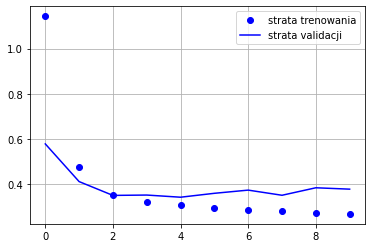

In [28]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(len(loss))

plt.figure()

plt.plot(epoch, loss, 'bo', label = 'strata trenowania')
plt.plot(epoch, val_loss, 'b', label = 'strata validacji')
plt.grid()
plt.legend()

plt.show()


In [ ]:
# przy sieci gesto połączonej błąd jest porównywalny do algortymu który jest napisany wczesniej

In [29]:
float_data.shape[-1]

14

In [30]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [31]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             epochs=20,
                             steps_per_epoch=50,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20


C:\Users\Grzegorz Mróz\AppData\Local\Temp\ipykernel_15200\484500943.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


50/50 [==============================] - 1970s 40s/step - loss: 0.3902 - val_loss: 0.3353
Epoch 2/20
50/50 [==============================] - 1866s 38s/step - loss: 0.3595 - val_loss: 0.3390
Epoch 3/20
50/50 [==============================] - 1815s 37s/step - loss: 0.3487 - val_loss: 0.3239
Epoch 4/20
50/50 [==============================] - 1789s 37s/step - loss: 0.3459 - val_loss: 0.3237
Epoch 5/20
50/50 [==============================] - 1784s 36s/step - loss: 0.3463 - val_loss: 0.3216
Epoch 6/20
50/50 [==============================] - 1776s 36s/step - loss: 0.3408 - val_loss: 0.3199
Epoch 7/20
50/50 [==============================] - 1819s 37s/step - loss: 0.3405 - val_loss: 0.3231
Epoch 8/20
50/50 [==============================] - 1835s 37s/step - loss: 0.3327 - val_loss: 0.3248
Epoch 9/20
50/50 [==============================] - 1835s 37s/step - loss: 0.3343 - val_loss: 0.3132
Epoch 10/20
50/50 [==============================] - 1832s 37s/step - loss: 0.3349 - val_loss: 0.3236


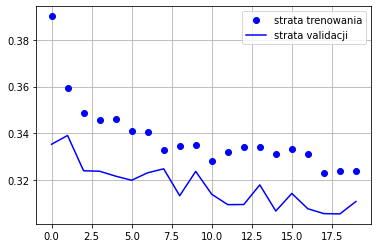

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(len(loss))

plt.figure()

plt.plot(epoch, loss, 'bo', label = 'strata trenowania')
plt.plot(epoch, val_loss, 'b', label = 'strata validacji')
plt.grid()
plt.legend()

plt.show()


In [ ]:
# drop out w RNN

In [23]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,#określa współczyniki orzucania jednostek rekurencyjnych
                    input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history= model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=40,# przy dropoutcie w RNN trzeba podac 2xilość epok 
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/40


C:\Users\Grzegorz Mróz\AppData\Local\Temp\ipykernel_16864\2690723728.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history= model.fit_generator(train_gen,


500/500 [==============================] - 1259s 3s/step - loss: 0.3893 - val_loss: 0.3257
Epoch 2/40
500/500 [==============================] - 1237s 2s/step - loss: 0.3560 - val_loss: 0.3203
Epoch 3/40
500/500 [==============================] - 1236s 2s/step - loss: 0.3465 - val_loss: 0.3147
Epoch 4/40
500/500 [==============================] - 1230s 2s/step - loss: 0.3400 - val_loss: 0.3199
Epoch 5/40
500/500 [==============================] - 1244s 2s/step - loss: 0.3349 - val_loss: 0.3158
Epoch 6/40
500/500 [==============================] - 1238s 2s/step - loss: 0.3319 - val_loss: 0.3200
Epoch 7/40
500/500 [==============================] - 1227s 2s/step - loss: 0.3257 - val_loss: 0.3196
Epoch 8/40
500/500 [==============================] - 1225s 2s/step - loss: 0.3237 - val_loss: 0.3425
Epoch 9/40
500/500 [==============================] - 1229s 2s/step - loss: 0.3180 - val_loss: 0.3282
Epoch 10/40
500/500 [==============================] - 1282s 3s/step - loss: 0.3164 - val_los

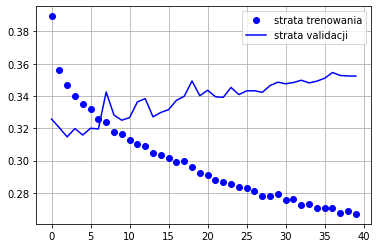

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(len(loss))

plt.figure()

plt.plot(epoch, loss, 'bo', label = 'strata trenowania')
plt.plot(epoch, val_loss, 'b', label = 'strata validacji')
plt.grid()
plt.legend()

plt.show()


In [ ]:

#zwiekszanie pojemności sieci (tam gdzie granicą jest overfiting xD)

In [87]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
#przy dodawaniu kolejniej warstwy trzeba ustawić recurrent_sequence=True(to powoduje ze wartstwa zwraca 
# zawsze 3wym. tensor)
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, 14)
                    ))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurent_dropout=0.5))
model.add(layes.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

TypeError: ('Keyword argument not understood:', 'recurent_dropout')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(len(loss))

plt.figure()

plt.plot(epoch, loss, 'bo', label = 'strata trenowania')
plt.plot(epoch, val_loss, 'b', label = 'strata validacji')
plt.grid()
plt.legend()

plt.show()